In this part we are going to implement glove:

first we go through importing required packages:

In [1]:
# first importing libraries
import base64
import requests
import numpy as np
import gdown
from zipfile import ZipFile
import os

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import pandas as pd
from torchvision.io import read_image
import re
import cv2
from skimage.transform import resize
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from torch.optim import lr_scheduler


from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

import time
import os
import copy
import string

from nltk.corpus import stopwords
import nltk
import itertools
nltk.download('stopwords')
import nltk 
nltk.download('stopwords')
nltk.download ('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

here we mount the drive where we stored our glove file

In [3]:
from google.colab import drive
drive.mount('/content/gdrive') # we use google drive to load files and save models there! so change path files based on your own data and run the code!

Mounted at /content/gdrive


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [5]:
!git clone https://github.com/XL2248/MSCTD.git

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 21.16 MiB/s, done.
Resolving deltas: 100% (617/617), done.
Updating files: 100% (934/934), done.


now we load the dataset:

In [6]:
with open('/content/MSCTD/MSCTD_data/ende/english_train.txt') as f:
    text_file_train = [line.rstrip('\n') for line in f]

In [7]:
with open('/content/MSCTD/MSCTD_data/ende/english_dev.txt') as f:
    text_file_dev = [line.rstrip('\n') for line in f]

In [8]:
with open('/content/MSCTD/MSCTD_data/ende/english_test.txt') as f:
    text_file_test = [line.rstrip('\n') for line in f]

here we specify punctuations, so we can remove them from the dataset

In [9]:
print(f'all possible punctuations = {string.punctuation}')
punc_remove = string.punctuation

all possible punctuations = !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [10]:
remove_translate = str.maketrans('', '', string.punctuation)

here we specify stopwords to be removed. we made sure that stop words like "no" , "nor" , "not" not be removed as they are effective in the sentiment classification

In [11]:
all_stopwords= stopwords.words('english')
chosen_stopword=[value for value in all_stopwords if value not in ["no","nor","not"]]
print(chosen_stopword)
print("no"in chosen_stopword)
print("nor"in chosen_stopword)
print("not"in chosen_stopword)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', '

In [12]:
print(text_file_dev[0])
print(text_file_train[0])
print(text_file_test[0])

He diagnosed Andy with growing pains.
Okay. I'm confused.
With this asshole?


here we use lemmatization to replace each word with that in the dictionaries, removing prefixes, suffixes, and tense affixes as well as changing comparative and supperlative adjective and adverbs too their normal form

In [13]:
lemmatizer=WordNetLemmatizer()

 train dataset without lemmatizer

In [14]:
all_txt_train = []
for txt in text_file_train:
  txt = txt.translate(remove_translate)
  txt = txt.lower()
  txt = txt.split()
  filtered_words = [word for word in txt if word not in stopwords.words('english')]
  text_final = ""
  for i in range(len(filtered_words)):
    text_final = text_final + filtered_words[i] + " "
  text_final = text_final[:-1]
  all_txt_train.append(text_final)

train dataset with lemmatizer

In [15]:
all_txt_train_lem = []
for txt in text_file_train:
  txt = txt.translate(remove_translate)
  txt = txt.lower()
  txt = txt.split()
  filtered_words = [word for word in txt if word not in stopwords.words('english')]
  text_final = ""
  lem_line=[] 
  for word in filtered_words:
    lem_line.append(lemmatizer.lemmatize(word)) 
  for i in range(len(lem_line)):
    text_final = text_final + lem_line[i] + " "
  text_final = text_final[:-1]
  all_txt_train_lem.append(text_final)


validation dataset without lemmatizer

In [16]:
all_txt_dev = []
for txt in text_file_dev:
  txt = txt.translate(remove_translate)
  txt = txt.lower()
  txt = txt.split()
  filtered_words = [word for word in txt if word not in stopwords.words('english')]
  text_final = ""
  for i in range(len(filtered_words)):
    text_final = text_final + filtered_words[i] + " "
  text_final = text_final[:-1]
  all_txt_dev.append(text_final)

validation dataset with lemmatizer

In [17]:
all_txt_dev_lem = []
for txt in text_file_dev:
  txt = txt.translate(remove_translate)
  txt = txt.lower()
  txt = txt.split()
  filtered_words = [word for word in txt if word not in stopwords.words('english')]
  text_final = ""
  lem_line=[] 
  for word in filtered_words:
    lem_line.append(lemmatizer.lemmatize(word)) 
  for i in range(len(lem_line)):
    text_final = text_final + lem_line[i] + " "
  text_final = text_final[:-1]
  all_txt_dev_lem.append(text_final)

test dataset without lemmatizer

In [18]:
all_txt_test = []
for txt in text_file_test:
  txt = txt.translate(remove_translate)
  txt = txt.lower()
  txt = txt.split()
  filtered_words = [word for word in txt if word not in stopwords.words('english')]
  text_final = ""
  for i in range(len(filtered_words)):
    text_final = text_final + filtered_words[i] + " "
  text_final = text_final[:-1]
  all_txt_test.append(text_final)


test dataset with lemmatizer

In [19]:
all_txt_test_lem = []
for txt in text_file_test:
  txt = txt.translate(remove_translate)
  txt = txt.lower()
  txt = txt.split()
  filtered_words = [word for word in txt if word not in stopwords.words('english')]
  text_final = ""
  lem_line=[] 
  for word in filtered_words:
    lem_line.append(lemmatizer.lemmatize(word)) 
  for i in range(len(lem_line)):
    text_final = text_final + lem_line[i] + " "
  text_final = text_final[:-1]
  all_txt_test_lem.append(text_final)

In [20]:
print(all_txt_train)
print(all_txt_train_lem)
print(all_txt_dev)
print(all_txt_dev_lem)
print(all_txt_test)
print(all_txt_test_lem)

['okay im confused', 'dont care go paris jane', 'im sorry tell something', 'go', 'im accessory murder', 'think youve helped enough', 'gaby please cant stand anymore', 'cant talk minute', 'honest', 'wait mean', 'called us station grilled us one one', 'didnt call', 'good question given whole thing', 'talking', 'bree wants revenge wants bring', 'gaby please', 'figure way make things better', 'dont talk', 'oh god brought', 'give', 'oh well never works', 'going say', 'theyre whole world nothing else', 'nothing else', 'thats bad position make deal', 'sorry', 'hey remember deal wanted make', 'least hes honest', 'wound taking different angle investigation', 'actually reason', 'mean', 'remember talking guy', 'yep', 'thats sauce mother uses', 'likes cooking italian according', 'interesting', 'ill spaghetti night', 'im hungry', 'oh um okay', 'dont give hour come', 'cut hot dogs little chunks mix sauce', 'dont hot dogs', 'oh right', 'hey', 'talking penny', 'whats wrong', 'cant hang roommates ex', 

In [21]:
from itertools import chain
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

here we tokenize the words and assign each a number. first we fit that on train dataset

In [22]:

for i in range(len(all_txt_train_lem)):
  all_txt_train_lem[i] =  '<shr> ' + "".join(all_txt_train_lem[i]) + ' <pia>'


tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(all_txt_train_lem)




vocab_size = len(tokenizer.word_index)+1
print(f"number of unique word in our created vocabulary = {vocab_size}")
print(tokenizer.word_index)






tokenized_txt_train_lem = []
MAXLEN = -1
for i in range(len(all_txt_train_lem)):
  tokenized = tokenizer.texts_to_sequences(all_txt_train_lem[i].split())
  tokenized = list(chain.from_iterable(tokenized))
  tokenized = np.asarray(tokenized)
  if (len(tokenized) > MAXLEN):
    MAXLEN = len(tokenized)
  tokenized_txt_train_lem.append(tokenized)
print(f"Max length of each line = {MAXLEN}")
print(f"first sample = {tokenized_txt_train_lem[0]}")







number of unique word in our created vocabulary = 9154
{'<oov>': 1, 'shr': 2, 'pia': 3, 'im': 4, 'know': 5, 'dont': 6, 'get': 7, 'like': 8, 'oh': 9, 'right': 10, 'well': 11, 'youre': 12, 'okay': 13, 'yeah': 14, 'go': 15, 'one': 16, 'got': 17, 'think': 18, 'thats': 19, 'gonna': 20, 'want': 21, 'need': 22, 'come': 23, 'look': 24, 'let': 25, 'going': 26, 'see': 27, 'good': 28, 'time': 29, 'back': 30, 'mean': 31, 'thing': 32, 'hey': 33, 'guy': 34, 'really': 35, 'say': 36, 'he': 37, 'cant': 38, 'u': 39, 'man': 40, 'take': 41, 'make': 42, 'didnt': 43, 'sorry': 44, 'something': 45, 'tell': 46, 'would': 47, 'little': 48, 'ill': 49, 'could': 50, 'way': 51, 'there': 52, 'day': 53, 'uh': 54, 'yes': 55, 'shes': 56, 'two': 57, 'ive': 58, 'never': 59, 'give': 60, 'whats': 61, 'wait': 62, 'said': 63, 'thought': 64, 'please': 65, 'much': 66, 'put': 67, 'people': 68, 'even': 69, 'love': 70, 'life': 71, 'still': 72, 'maybe': 73, 'help': 74, 'god': 75, 'year': 76, 'talk': 77, 'work': 78, 'anything': 79, 

then we apply the fitted tokenizaton on validation dataset

In [23]:
for i in range(len(all_txt_dev_lem)):
  all_txt_dev_lem[i] =  '<shr> ' + "".join(all_txt_dev_lem[i]) + ' <pia>'

tokenized_txt_dev_lem= []
for i in range(len(all_txt_dev_lem)):
  tokenized = tokenizer.texts_to_sequences(all_txt_dev_lem[i].split())
  tokenized = list(chain.from_iterable(tokenized))
  tokenized = np.asarray(tokenized)
  if (len(tokenized) > MAXLEN):
    MAXLEN = len(tokenized)
  tokenized_txt_dev_lem.append(tokenized)
print(f"Max length of each line = {MAXLEN}")
print(f"first sample = {tokenized_txt_dev_lem[0]}")

Max length of each line = 13
first sample = [   2 4267 2944 1607  558    3]


and finally on the test dataset

In [24]:
for i in range(len(all_txt_test_lem)):
  all_txt_test_lem[i] =  '<shr> ' + "".join(all_txt_test_lem[i]) + ' <pia>'

tokenized_txt_test_lem = []
MAXLEN = -1
for i in range(len(all_txt_test_lem)):
  tokenized = tokenizer.texts_to_sequences(all_txt_test_lem[i].split())
  tokenized = list(chain.from_iterable(tokenized))
  tokenized = np.asarray(tokenized)
  if (len(tokenized) > MAXLEN):
    MAXLEN = len(tokenized)
  tokenized_txt_test_lem.append(tokenized)
print(f"Max length of each line = {MAXLEN}")
print(f"first sample = {tokenized_txt_test_lem[0]}")


Max length of each line = 12
first sample = [  2 560   3]


now we do the word embedding using glove

In [25]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/gdrive/MyDrive/glove/glove.6B.50d.txt')
for line in f:
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [26]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in tokenizer.word_index.items():
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
   embedding_matrix[i] = embedding_vector

In [27]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

In [28]:
e = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False)

here we pad the datasets

In [29]:
padded_all_train= pad_sequences(list(tokenized_txt_train_lem), maxlen=MAXLEN, padding="post")
padded_all_dev = pad_sequences(list(tokenized_txt_dev_lem), maxlen=MAXLEN, padding="post")
padded_all_test = pad_sequences(list(tokenized_txt_test_lem), maxlen=MAXLEN, padding="post")

from now on we define some different models with different architecture and whether or not their glove wordembedding will be fine tuned for our case

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from sklearn.model_selection import train_test_split


e = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False)
model = Sequential()
model.add(e)
model.add(LSTM(512, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          457700    
                                                                 
 lstm (LSTM)                 (None, 512)               1153024   
                                                                 
 dense (Dense)               (None, 3)                 1539      
                                                                 
Total params: 1,612,263
Trainable params: 1,154,563
Non-trainable params: 457,700
_________________________________________________________________
None


now we load the labels

In [31]:
# loading sentiments
with open('/content/MSCTD/MSCTD_data/ende/sentiment_train.txt') as f:
  sentiment_train = [int(line.rstrip('\n')) for line in f]
with open('/content/MSCTD/MSCTD_data/ende/sentiment_dev.txt') as f:
  sentiment_dev = [int(line.rstrip('\n')) for line in f]
with open('/content/MSCTD/MSCTD_data/ende/sentiment_test.txt') as f:
  sentiment_test = [int(line.rstrip('\n')) for line in f]

In [32]:
import tensorflow as tf
sentiment_train_1hot= tf.convert_to_tensor(tf.keras.utils.to_categorical(np.asarray(sentiment_train)))
sentiment_dev_1hot = tf.convert_to_tensor(tf.keras.utils.to_categorical(np.asarray(sentiment_dev)))

In [33]:
sentiment_train_1hot[1]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>

In [34]:
array_train = np.asarray(padded_all_train)
array_dev = np.asarray(padded_all_dev)

In [35]:
array_test = np.asarray(padded_all_test)

here we fit our first model

In [ ]:
batch_size = 64
model.fit(array_train, sentiment_train_1hot,validation_data=(array_dev, sentiment_dev_1hot),epochs =10 , batch_size=batch_size, verbose = 1)

Epoch 1/10
317/317 [==============================] - 109s 332ms/step - loss: 1.0381 - accuracy: 0.4659 - val_loss: 1.0309 - val_accuracy: 0.4882
Epoch 2/10
317/317 [==============================] - 104s 330ms/step - loss: 1.0157 - accuracy: 0.4936 - val_loss: 1.0223 - val_accuracy: 0.4871
Epoch 3/10
317/317 [==============================] - 102s 322ms/step - loss: 0.9991 - accuracy: 0.5086 - val_loss: 1.0081 - val_accuracy: 0.4942
Epoch 4/10
317/317 [==============================] - 104s 329ms/step - loss: 0.9861 - accuracy: 0.5171 - val_loss: 1.0025 - val_accuracy: 0.5042
Epoch 5/10
317/317 [==============================] - 102s 322ms/step - loss: 0.9744 - accuracy: 0.5260 - val_loss: 0.9864 - val_accuracy: 0.5084
Epoch 6/10
317/317 [==============================] - 104s 329ms/step - loss: 0.9654 - accuracy: 0.5355 - val_loss: 0.9975 - val_accuracy: 0.5052
Epoch 7/10
317/317 [==============================] - 103s 324ms/step - loss: 0.9561 - accuracy: 0.5420 - val_loss: 0.9789 -

best accuracy for this model is 52.12% 

next comes the second model:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from sklearn.model_selection import train_test_split


e = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=True)
model1 = Sequential()
model1.add(e)
model1.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.2)))
model1.add(Dense(3,activation='softmax'))
model1.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 50)          457700    
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             2306048   
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 2,766,823
Trainable params: 2,766,823
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 64
model1.fit(array_train, sentiment_train_1hot,validation_data=(array_dev, sentiment_dev_1hot),epochs = 5, batch_size=batch_size, verbose = 1)

Epoch 1/5
317/317 [==============================] - 216s 663ms/step - loss: 1.0200 - accuracy: 0.4890 - val_loss: 1.0005 - val_accuracy: 0.5035
Epoch 2/5
317/317 [==============================] - 209s 660ms/step - loss: 0.9580 - accuracy: 0.5385 - val_loss: 1.0004 - val_accuracy: 0.5114
Epoch 3/5
317/317 [==============================] - 209s 661ms/step - loss: 0.9116 - accuracy: 0.5750 - val_loss: 0.9853 - val_accuracy: 0.5214
Epoch 4/5
317/317 [==============================] - 208s 657ms/step - loss: 0.8695 - accuracy: 0.6043 - val_loss: 0.9869 - val_accuracy: 0.5191
Epoch 5/5
317/317 [==============================] - 209s 660ms/step - loss: 0.8250 - accuracy: 0.6279 - val_loss: 1.0197 - val_accuracy: 0.5191


best accuracy: 52.14%

third model:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from sklearn.model_selection import train_test_split


e = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False)
model2 = Sequential()
model2.add(e)
model2.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(3,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          457700    
                                                                 
 bidirectional_1 (Bidirectio  (None, 1024)             2306048   
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 2,766,823
Trainable params: 2,309,123
Non-trainable params: 457,700
_________________________________________________________________
None


In [ ]:
batch_size = 64
model2.fit(array_train, sentiment_train_1hot,validation_data=(array_dev, sentiment_dev_1hot),epochs = 7, batch_size=batch_size, verbose = 1)

Epoch 1/7
317/317 [==============================] - 207s 635ms/step - loss: 1.0337 - accuracy: 0.4767 - val_loss: 1.0193 - val_accuracy: 0.4829
Epoch 2/7
317/317 [==============================] - 199s 628ms/step - loss: 1.0024 - accuracy: 0.5050 - val_loss: 1.0194 - val_accuracy: 0.4851
Epoch 3/7
317/317 [==============================] - 199s 628ms/step - loss: 0.9893 - accuracy: 0.5176 - val_loss: 0.9961 - val_accuracy: 0.5108
Epoch 4/7
317/317 [==============================] - 200s 630ms/step - loss: 0.9792 - accuracy: 0.5226 - val_loss: 0.9916 - val_accuracy: 0.5031
Epoch 5/7
317/317 [==============================] - 200s 630ms/step - loss: 0.9652 - accuracy: 0.5282 - val_loss: 0.9886 - val_accuracy: 0.5072
Epoch 6/7
317/317 [==============================] - 200s 630ms/step - loss: 0.9547 - accuracy: 0.5378 - val_loss: 0.9852 - val_accuracy: 0.5106
Epoch 7/7
317/317 [==============================] - 199s 629ms/step - loss: 0.9425 - accuracy: 0.5458 - val_loss: 0.9848 - val_ac

best accuracy: 51.18%

fourth model:

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from sklearn.model_selection import train_test_split


e = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=True)
model3 = Sequential()
model3.add(e)
model3.add(LSTM(64,return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model3.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(3,activation='softmax'))
model3.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model3.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          457700    
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          29440     
                                                                 
 lstm_2 (LSTM)               (None, 16)                5184      
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 492,375
Trainable params: 492,375
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
batch_size = 64
model3.fit(array_train, sentiment_train_1hot,validation_data=(array_dev, sentiment_dev_1hot),epochs = 5, batch_size=batch_size, verbose = 1)

Epoch 1/5
317/317 [==============================] - 32s 81ms/step - loss: 1.0238 - accuracy: 0.4787 - val_loss: 0.9989 - val_accuracy: 0.4991
Epoch 2/5
317/317 [==============================] - 28s 89ms/step - loss: 0.9619 - accuracy: 0.5399 - val_loss: 0.9878 - val_accuracy: 0.5177
Epoch 3/5
317/317 [==============================] - 18s 56ms/step - loss: 0.9179 - accuracy: 0.5725 - val_loss: 0.9880 - val_accuracy: 0.5214
Epoch 4/5
317/317 [==============================] - 14s 44ms/step - loss: 0.8807 - accuracy: 0.5963 - val_loss: 0.9989 - val_accuracy: 0.5319
Epoch 5/5
317/317 [==============================] - 14s 45ms/step - loss: 0.8432 - accuracy: 0.6230 - val_loss: 1.0112 - val_accuracy: 0.5337


best accuracy: 53.37%

fifth model:

In [ ]:
e = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=True)
model4 = Sequential()
model4.add(e)
model4.add(Bidirectional(LSTM(64,return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model4.add(Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2)))
model4.add(Dense(3,activation='softmax'))
model4.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 50)          457700    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        58880     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 535,239
Trainable params: 535,239
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 128
model4.fit(array_train, sentiment_train_1hot,validation_data=(array_dev, sentiment_dev_1hot),epochs = 10, batch_size=batch_size, verbose = 1)

Epoch 1/10
159/159 [==============================] - 30s 124ms/step - loss: 1.0253 - accuracy: 0.4809 - val_loss: 1.0131 - val_accuracy: 0.4906
Epoch 2/10
159/159 [==============================] - 19s 118ms/step - loss: 0.9648 - accuracy: 0.5377 - val_loss: 0.9878 - val_accuracy: 0.5187
Epoch 3/10
159/159 [==============================] - 19s 121ms/step - loss: 0.9265 - accuracy: 0.5690 - val_loss: 0.9844 - val_accuracy: 0.5193
Epoch 4/10
159/159 [==============================] - 20s 126ms/step - loss: 0.8913 - accuracy: 0.5909 - val_loss: 0.9995 - val_accuracy: 0.5240
Epoch 5/10
159/159 [==============================] - 18s 115ms/step - loss: 0.8563 - accuracy: 0.6155 - val_loss: 1.0052 - val_accuracy: 0.5272
Epoch 6/10
159/159 [==============================] - 18s 115ms/step - loss: 0.8195 - accuracy: 0.6346 - val_loss: 1.0154 - val_accuracy: 0.5254
Epoch 7/10
159/159 [==============================] - 18s 116ms/step - loss: 0.7804 - accuracy: 0.6585 - val_loss: 1.0415 - val_ac

best accuracy:52.72%

sixth model:

In [ ]:
e = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=True)
model5 = Sequential()
model5.add(e)
model5.add(LSTM(256,return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model5.add(LSTM(128,return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model5.add(LSTM(32,return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model5.add(LSTM(16,return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model5.add(LSTM(8,return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model5.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model5.add(Dense(3,activation='softmax'))
model5.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model5.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 50)          457700    
                                                                 
 lstm_53 (LSTM)              (None, None, 256)         314368    
                                                                 
 lstm_54 (LSTM)              (None, None, 128)         197120    
                                                                 
 lstm_55 (LSTM)              (None, None, 32)          20608     
                                                                 
 lstm_56 (LSTM)              (None, None, 16)          3136      
                                                                 
 lstm_57 (LSTM)              (None, None, 8)           800       
                                                                 
 bidirectional_20 (Bidirecti  (None, 128)            

In [ ]:
batch_size = 128
model5.fit(array_train, sentiment_train_1hot,validation_data=(array_dev, sentiment_dev_1hot),epochs = 5, batch_size=batch_size, verbose = 1)

Epoch 1/5
159/159 [==============================] - 80s 385ms/step - loss: 1.0475 - accuracy: 0.4540 - val_loss: 1.0161 - val_accuracy: 0.4886
Epoch 2/5
159/159 [==============================] - 59s 368ms/step - loss: 0.9798 - accuracy: 0.5264 - val_loss: 0.9862 - val_accuracy: 0.5147
Epoch 3/5
159/159 [==============================] - 59s 369ms/step - loss: 0.9432 - accuracy: 0.5568 - val_loss: 0.9861 - val_accuracy: 0.5232
Epoch 4/5
159/159 [==============================] - 59s 369ms/step - loss: 0.9189 - accuracy: 0.5744 - val_loss: 0.9881 - val_accuracy: 0.5279
Epoch 5/5
159/159 [==============================] - 59s 369ms/step - loss: 0.8898 - accuracy: 0.5967 - val_loss: 0.9821 - val_accuracy: 0.5198


best accuracy:52.79%

as the best accuracy in the last epoch among the models goes to model3 (fourth model), we choose model3 as our best choice and we evaluate that below:

model3 metrics like f1 score is as follows:

first for train

In [45]:
from sklearn.metrics import classification_report
y_pred = model3.predict(array_train, batch_size=64, verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(sentiment_train, y_pred_bool))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66      6922
           1       0.66      0.74      0.70      7835
           2       0.69      0.55      0.61      5483

    accuracy                           0.67     20240
   macro avg       0.67      0.65      0.66     20240
weighted avg       0.67      0.67      0.66     20240



then validation

In [44]:
from sklearn.metrics import classification_report
y_pred = model3.predict(array_dev, batch_size=64, verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(sentiment_dev, y_pred_bool))

              precision    recall  f1-score   support

           0       0.51      0.53      0.52      1777
           1       0.53      0.63      0.58      1838
           2       0.58      0.42      0.49      1448

    accuracy                           0.53      5063
   macro avg       0.54      0.53      0.53      5063
weighted avg       0.54      0.53      0.53      5063



then test:

In [43]:
from sklearn.metrics import classification_report
y_pred = model3.predict(array_test, batch_size=64, verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(sentiment_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.40      0.57      0.47      1298
           1       0.61      0.59      0.60      2163
           2       0.61      0.43      0.51      1606

    accuracy                           0.53      5067
   macro avg       0.54      0.53      0.52      5067
weighted avg       0.56      0.53      0.54      5067



now we try to plot confusion matrix for train,dev ,and test:

In [46]:
print(array_train.shape)
y_train=np.argmax(model3.predict(array_train),axis=1)
print(y_train.shape)

(20240, 12)
633/633 [==============================] - 3s 5ms/step
(20240,)


In [47]:
print(array_dev.shape)
y_dev=np.argmax(model3.predict(array_dev),axis=1)
print(y_dev.shape)

(5063, 12)
159/159 [==============================] - 1s 6ms/step
(5063,)


In [48]:
print(array_test.shape)
y_test=np.argmax(model3.predict(array_test),axis=1)
print(y_test.shape)

(5067, 12)
159/159 [==============================] - 1s 6ms/step
(5067,)


train:

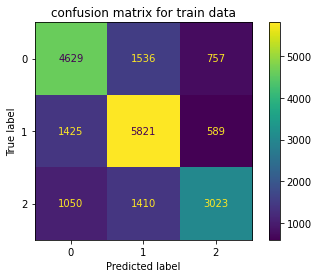

In [49]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(sentiment_train, y_train)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for train data')

plt.show()

dev:

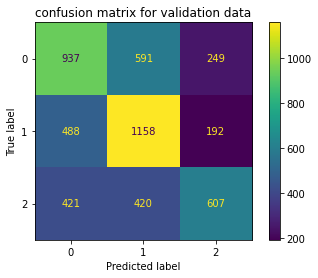

In [50]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(sentiment_dev, y_dev)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for validation data')

plt.show()


test:

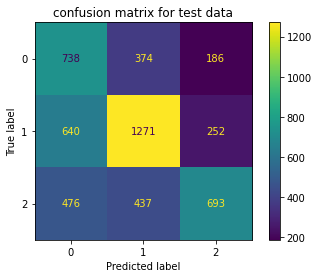

In [51]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(sentiment_test, y_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for test data')

plt.show()

it seems that the best accuracy on test set is about 53.4% it is way better than
the results in phase 1